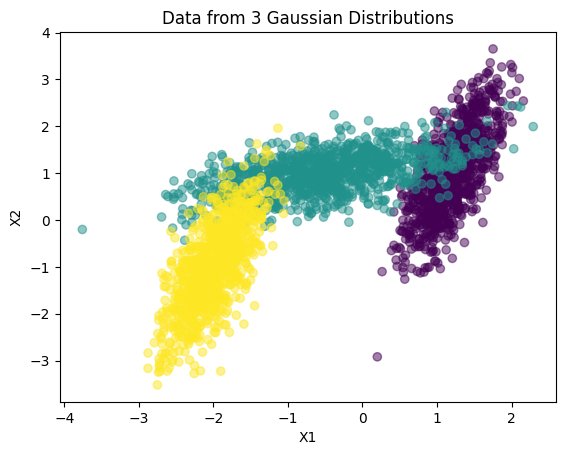

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Means and covariance matrices
mu_1 = np.array([1.2, 1])
sigma_1 = np.array([[0.1, 0.2], [0.2, 0.8]])

mu_2 = np.array([-0.5, 1])
sigma_2 = np.array([[0.8, 0.2], [0.2, 0.2]])

mu_3 = np.array([-2, -1])
sigma_3 = np.array([[0.1, 0.2], [0.2, 0.8]])

# Generating data points
data_1 = np.random.multivariate_normal(mu_1, sigma_1, 1000)
data_2 = np.random.multivariate_normal(mu_2, sigma_2, 1000)
data_3 = np.random.multivariate_normal(mu_3, sigma_3, 1000)

# Combining data
data = np.vstack((data_1, data_2, data_3))
labels = np.array([1]*1000 + [2]*1000 + [3]*1000)

# Plotting the data
plt.scatter(data[:,0], data[:,1], c=labels, alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data from 3 Gaussian Distributions')
plt.show()



In [2]:
# define the GMM model

from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, n_iter):
        self.n_components = n_components
        self.n_iter = n_iter

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = np.random.choice(X.flatten(), (self.n_components, self.m))
        self.cov = [np.cov(X.T) for _ in range(self.n_components)]

    def e_step(self, X):
        self.resp = np.zeros((self.n, self.n_components))
        for k in range(self.n_components):
            self.resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.cov[k])
        self.resp = self.resp / self.resp.sum(axis=1, keepdims=1)

    def m_step(self, X):
        for k in range(self.n_components):
            Nk = np.sum(self.resp[:, k], axis=0)
            self.means[k] = (1 / Nk) * np.sum(self.resp[:, k, np.newaxis] * X, axis=0)
            self.cov[k] = (1 / Nk) * np.dot((self.resp[:, k, np.newaxis] * (X - self.means[k])).T, (X - self.means[k]))
            self.weights[k] = Nk / self.n

    def fit(self, X):
        self.initialize(X)
        
        for _ in range(self.n_iter):
            self.e_step(X)
            self.m_step(X)

    def predict(self, X):
        probs = np.zeros((self.n, self.n_components))
        for k in range(self.n_components):
            probs[:, k] = multivariate_normal.pdf(X, self.means[k], self.cov[k])
        return np.argmax(probs, axis=1)




C:\Users\qs9960\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


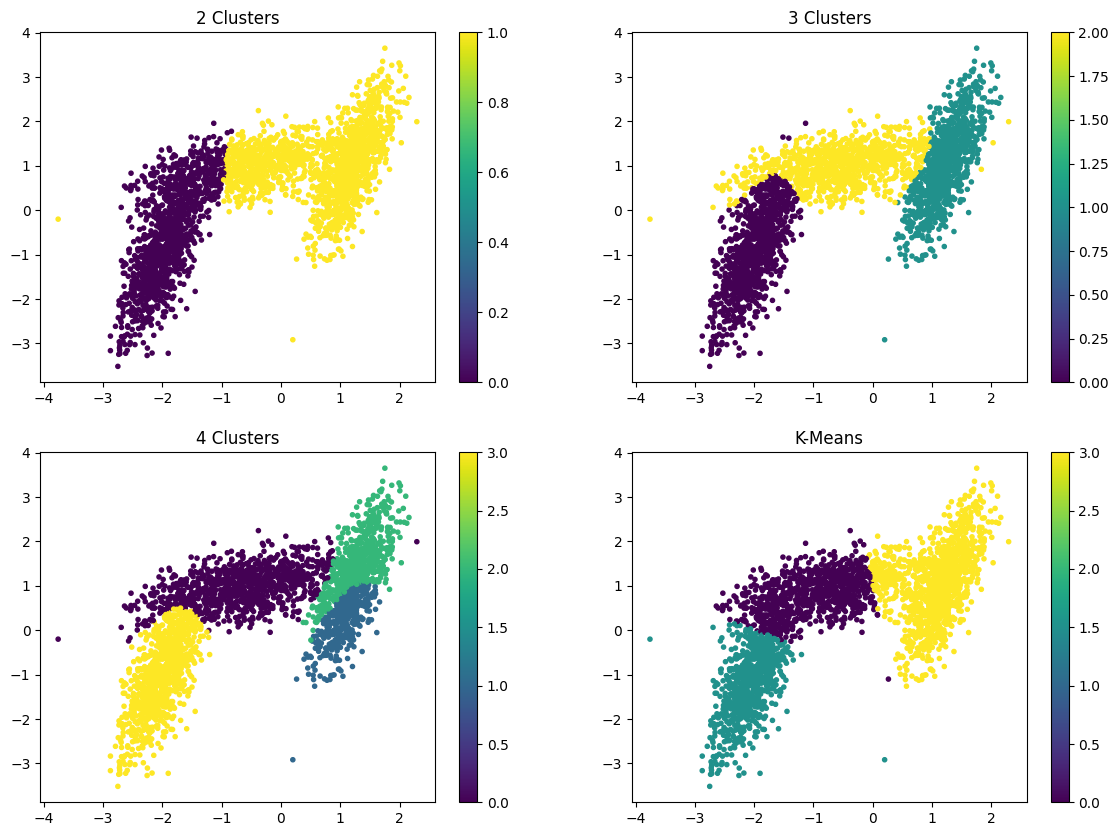

In [3]:
from sklearn.cluster import KMeans

# Initialize and fit GMM

gmm = GMM(n_components=3, n_iter=10)
gmm.fit(data)

# Predict cluster labels
labels = gmm.predict(data)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
K_values = [2, 3, 4]

# K-means with the same number of clusters as GMM

kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
labels_kmeans = kmeans.predict(data)

for i, K in enumerate(K_values):
    gmm = GMM(n_components=K, n_iter=20)
    gmm.fit(data)
    predictions = gmm.predict(data)
    
    # Select the subplot
    ax = axs[i//2, i%2]
    sc = ax.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis', marker='.')
    ax.set_title(f"{K} Clusters")
    plt.colorbar(sc, ax=ax)
    
    
axs[1,1].scatter(data[:,0], data[:,1], c=labels_kmeans, cmap='viridis', marker='.')
axs[1,1].set_title(f"K-Means")
plt.colorbar(sc, ax=axs[1,1])
plt.show()

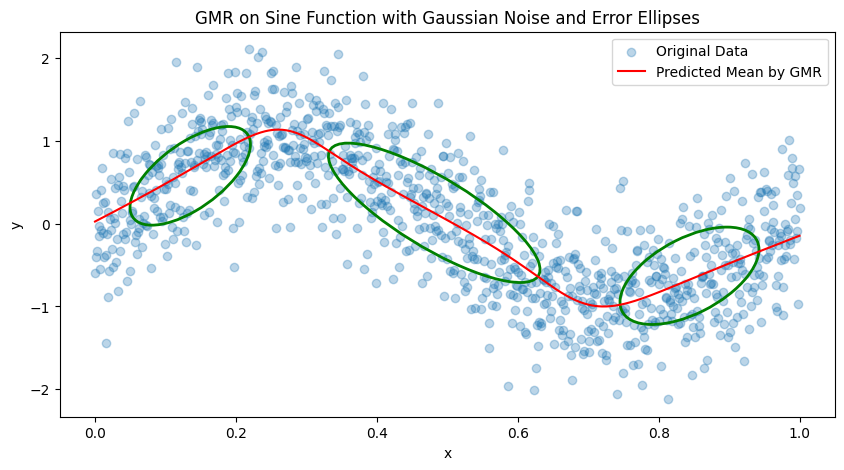

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from gmr import GMM

# Generating data from a sine function with Gaussian noise
x = np.linspace(0, 1, 1000)[:, np.newaxis]  # Reshaping for compatibility
y = np.sin(2 * np.pi * x) + np.random.normal(0, 0.5, x.shape)

# Combine x and y into a single dataset
data = np.hstack((x, y))

# Fit a GMM to this data
gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(data)

# Using GMR to predict y-values based on x-values
x1_index = [0]  # Index of x in the data
predicted_y_mean = gmm.predict(x1_index, x)

# Getting ellipses for each Gaussian component
ellipses = gmm.to_ellipses(factor=1.0)

# Plotting original data, predicted mean, and ellipses
plt.figure(figsize=(10, 5))
plt.scatter(x, y, alpha=0.3, label='Original Data')
plt.plot(x, predicted_y_mean, color='red', label='Predicted Mean by GMR')

# Plotting the ellipses
for mean, (angle, width, height) in ellipses:
    ell = Ellipse(xy=mean, width=2*width, height=2*height, angle=np.degrees(angle), 
                  edgecolor='green', fc='None', lw=2)
    plt.gca().add_patch(ell)

plt.title('GMR on Sine Function with Gaussian Noise and Error Ellipses')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
